In [1]:
import pandas as pd

# Load JSON Files into Pandas Dataframe

In [2]:
filename = 'cluster_20-trump_ president_ king.json'
path = './lda_clustered_json/'+filename
 
with open(path, encoding='utf-8', mode='r') as currentFile:
    df = pd.read_json(currentFile, orient='index')

df.head(3)

,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,clusterID,topic_percentage,topic_keywords,filtered_maintext
35,"07/14/2021, 01:04:12","07/14/2021, 01:04:12","06/12/2021, 15:53:42",By Pam Benson The intelligence community - not...,en,security.blogs.cnn.com,By Pam Benson The intelligence community - not...,Official: Changes to Benghazi talking points m...,https://security.blogs.cnn.com/2012/11/19/offi...,20,0.53227,"trump, president, king, obama, house, stone, h...",pam benson intelligence community white house ...
37,"07/14/2021, 01:04:12","07/14/2021, 01:04:12","06/12/2021, 15:22:34",To complete your CNN profile and ensure you ar...,en,www.cnn.com,To complete your CNN profile and ensure you ar...,Evan McMullin runs for White House to take on ...,https://www.cnn.com/2016/08/08/politics/evan-m...,20,0.98567,"trump, president, king, obama, house, stone, h...",profile account button conditions privacy poli...
60,"07/14/2021, 01:08:34","07/14/2021, 01:08:34","06/13/2021, 06:29:30",To complete your CNN profile and ensure you ar...,en,www.cnn.com,To complete your CNN profile and ensure you ar...,Deputy AG defends AP subpoenas | CNN,https://www.cnn.com/2013/05/14/us/justice-ap-p...,20,0.65164,"trump, president, king, obama, house, stone, h...",profile account button conditions privacy poli...


In [3]:
amount_of_articles = len(df["filtered_maintext"])
print(f"Amount of articles: {amount_of_articles}")
processed_articles = df['filtered_maintext']

Amount of articles: 9899


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfconverter = TfidfVectorizer(lowercase=True, stop_words='english', min_df=0.05 , max_df=0.6)  
tfidf = tfidfconverter.fit_transform(processed_articles)
words = tfidfconverter.get_feature_names()
print(tfidf)

  (0, 358)	0.04187934448214907
  (0, 726)	0.019535736185985763
  (0, 662)	0.02982178096413444
  (0, 238)	0.039497745371298486
  (0, 668)	0.04240645378786761
  (0, 606)	0.0753536205897937
  (0, 516)	0.028552183299019634
  (0, 488)	0.04076590384798725
  (0, 147)	0.0457561397560888
  (0, 613)	0.06129741037374882
  (0, 457)	0.035819630827409486
  (0, 389)	0.03440039864649566
  (0, 288)	0.03493602113688847
  (0, 387)	0.03287563052201695
  (0, 83)	0.044864642892631104
  (0, 297)	0.14162945196115412
  (0, 489)	0.04045267783562697
  (0, 739)	0.05904934502875641
  (0, 412)	0.07115375791607371
  (0, 276)	0.04258214499770199
  (0, 649)	0.0435194269450302
  (0, 222)	0.07000730491902885
  (0, 57)	0.035819630827409486
  (0, 202)	0.02978355005242834
  (0, 258)	0.03705362373152568
  :	:
  (9898, 408)	0.12465263263213797
  (9898, 441)	0.1689030508791322
  (9898, 254)	0.09217886095145895
  (9898, 566)	0.08585685380891703
  (9898, 241)	0.10962709335047421
  (9898, 378)	0.08836659920042579
  (9898, 430)	0

In [5]:
from sklearn.metrics.pairwise import cosine_distances

cosine_similarity = cosine_distances(tfidf)
cosine_similarity

array([[0.        , 0.92062385, 0.75031194, ..., 0.91756832, 0.78152125,
        0.82355272],
       [0.92062385, 0.        , 0.85941121, ..., 0.95150893, 0.94356035,
        0.8900695 ],
       [0.75031194, 0.85941121, 0.        , ..., 0.90483841, 0.63555379,
        0.7678456 ],
       ...,
       [0.91756832, 0.95150893, 0.90483841, ..., 0.        , 0.92324768,
        0.92177877],
       [0.78152125, 0.94356035, 0.63555379, ..., 0.92324768, 0.        ,
        0.7985514 ],
       [0.82355272, 0.8900695 , 0.7678456 , ..., 0.92177877, 0.7985514 ,
        0.        ]])

In [6]:
from sklearn.cluster import AffinityPropagation

In [7]:
'''
clustering = AffinityPropagation(convergence_iter=5, affinity='precomputed', random_state=10)
clustering.fit(cosine_similarity)
labels = clustering.labels_
print(labels.dtype)
#cluster_centers = clustering.cluster_centers_
cluster_centers_indices = clustering.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
print(n_clusters_)'''

"\nclustering = AffinityPropagation(convergence_iter=5, affinity='precomputed', random_state=10)\nclustering.fit(cosine_similarity)\nlabels = clustering.labels_\nprint(labels.dtype)\n#cluster_centers = clustering.cluster_centers_\ncluster_centers_indices = clustering.cluster_centers_indices_\nn_clusters_ = len(cluster_centers_indices)\nprint(n_clusters_)"

In [8]:
'''
import matplotlib.pyplot as plt
from itertools import cycle

plt.close('all')
plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = cosine_similarity[cluster_centers_indices[k]]
    plt.plot(cosine_similarity[class_members, 0], cosine_similarity[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in cosine_similarity[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()'''

"\nimport matplotlib.pyplot as plt\nfrom itertools import cycle\n\nplt.close('all')\nplt.figure(1)\nplt.clf()\n\ncolors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')\nfor k, col in zip(range(n_clusters_), colors):\n    class_members = labels == k\n    cluster_center = cosine_similarity[cluster_centers_indices[k]]\n    plt.plot(cosine_similarity[class_members, 0], cosine_similarity[class_members, 1], col + '.')\n    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,\n             markeredgecolor='k', markersize=14)\n    for x in cosine_similarity[class_members]:\n        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)\n\nplt.title('Estimated number of clusters: %d' % n_clusters_)\nplt.show()"

In [9]:
'''
df['processed_articles'] = processed_articles
df['affpropID'] = clustering.labels_'''


"\ndf['processed_articles'] = processed_articles\ndf['affpropID'] = clustering.labels_"

In [10]:
df.head()

,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,clusterID,topic_percentage,topic_keywords,filtered_maintext
35,"07/14/2021, 01:04:12","07/14/2021, 01:04:12","06/12/2021, 15:53:42",By Pam Benson The intelligence community - not...,en,security.blogs.cnn.com,By Pam Benson The intelligence community - not...,Official: Changes to Benghazi talking points m...,https://security.blogs.cnn.com/2012/11/19/offi...,20,0.53227,"trump, president, king, obama, house, stone, h...",pam benson intelligence community white house ...
37,"07/14/2021, 01:04:12","07/14/2021, 01:04:12","06/12/2021, 15:22:34",To complete your CNN profile and ensure you ar...,en,www.cnn.com,To complete your CNN profile and ensure you ar...,Evan McMullin runs for White House to take on ...,https://www.cnn.com/2016/08/08/politics/evan-m...,20,0.98567,"trump, president, king, obama, house, stone, h...",profile account button conditions privacy poli...
60,"07/14/2021, 01:08:34","07/14/2021, 01:08:34","06/13/2021, 06:29:30",To complete your CNN profile and ensure you ar...,en,www.cnn.com,To complete your CNN profile and ensure you ar...,Deputy AG defends AP subpoenas | CNN,https://www.cnn.com/2013/05/14/us/justice-ap-p...,20,0.65164,"trump, president, king, obama, house, stone, h...",profile account button conditions privacy poli...
68,"07/14/2021, 01:13:12","07/14/2021, 01:13:12","06/13/2021, 14:42:24",Representative Joe L. Barton on Thursday quick...,en,thecaucus.blogs.nytimes.com,Representative Joe L. Barton on Thursday quick...,Barton: What I Really Meant to Say - The New Y...,https://thecaucus.blogs.nytimes.com/2010/06/17...,20,0.74849,"trump, president, king, obama, house, stone, h...",joe barton remark liability fund uproar democr...
104,"07/14/2021, 01:17:07","07/14/2021, 01:17:07","06/13/2021, 21:41:10",It doesn't matter. That's what some in the med...,en,www.breitbart.com,It doesn't matter. That's what some in the med...,Hillary Clinton's Long History of Hiding Docum...,https://www.breitbart.com/politics/2015/03/04/...,20,0.68846,"trump, president, king, obama, house, stone, h...",secretary hillary clinton decision server scru...


In [11]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn import metrics
from tqdm import tqdm
from scipy.spatial.distance import cdist
import numpy as np


In [12]:
max_clusters = 10

In [13]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}

last_distortion = 0

all_kmeans_models = []

K = range(2,max_clusters)
X = np.matrix(tfidf.toarray())
for i in tqdm(K):
    print("Iteration: " + str(i))
    kMeans = KMeans(n_clusters=i, max_iter=400).fit(tfidf)
    kMeans.predict(tfidf)
    labels = kMeans.labels_
    cluster_centers = kMeans.cluster_centers_
    inertias.append(kMeans.inertia_)
    distortions.append(sum(np.min(cdist(X, cluster_centers, 'euclidean'), axis=1)) / X.shape[0])

    this_silhouette = metrics.silhouette_score(tfidf.toarray(), labels, metric='sqeuclidean')

    print("Silhouette Score: " + str(this_silhouette))

    mapping1[i] =  sum(np.min(cdist(X, cluster_centers, 'euclidean'), axis=1)) / X.shape[0]
    mapping2[i] = kMeans.inertia_

    all_kmeans_models.append(kMeans)

    common_words = kMeans.cluster_centers_.argsort()[:,-1:-11:-1]
    for num, centroid in enumerate(common_words):
        print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

  0%|          | 0/8 [00:00<?, ?it/s]

Iteration: 2


 12%|█▎        | 1/8 [00:41<04:50, 41.47s/it]

Silhouette Score: 0.027075485550188908
0 : clinton, biden, party, democrats, obama, campaign, republicans, senate, republican, election
1 : obama, white, administration, security, official, russia, investigation, donald, intelligence, mueller
Iteration: 3


 25%|██▌       | 2/8 [01:31<04:38, 46.36s/it]

Silhouette Score: 0.02282323662961954
0 : mueller, investigation, intelligence, russia, fbi, official, committee, counsel, comey, attorney
1 : clinton, hillary, sanders, campaign, obama, candidate, voter, donald, bernie, election
2 : obama, biden, senate, democrats, party, republicans, white, donald, campaign, policy
Iteration: 4


 38%|███▊      | 3/8 [02:24<04:07, 49.48s/it]

Silhouette Score: 0.03065637200429271
0 : mueller, investigation, russia, intelligence, fbi, counsel, committee, official, comey, attorney
1 : obama, senate, republicans, white, party, democrats, republican, campaign, donald, administration
2 : biden, newsletters, manage, joe, election, impeachment, democrats, policy, privacy, sign
3 : clinton, hillary, sanders, campaign, obama, candidate, donald, voter, election, party
Iteration: 5


 50%|█████     | 4/8 [03:25<03:36, 54.01s/it]

Silhouette Score: 0.036246848685262845
0 : biden, newsletters, manage, joe, election, impeachment, democrats, policy, privacy, sign
1 : mueller, investigation, fbi, russia, counsel, comey, attorney, intelligence, campaign, justice
2 : clinton, hillary, sanders, campaign, obama, candidate, donald, voter, election, bernie
3 : senate, republicans, party, democrats, republican, gop, vote, election, obama, sen
4 : obama, white, administration, security, donald, united, policy, official, bush, states
Iteration: 6


 62%|██████▎   | 5/8 [04:29<02:52, 57.53s/it]

Silhouette Score: 0.037286605929582946
0 : clinton, hillary, campaign, sanders, obama, candidate, donald, voter, election, party
1 : biden, newsletters, joe, manage, election, democrats, impeachment, policy, sanders, privacy
2 : donald, campaign, breitbart, white, policy, woman, right, twitter, candidate, cruz
3 : obama, administration, security, official, white, intelligence, united, iran, states, government
4 : senate, republicans, democrats, party, republican, gop, vote, obama, election, committee
5 : mueller, investigation, fbi, counsel, comey, russia, attorney, justice, campaign, committee
Iteration: 7


 75%|███████▌  | 6/8 [05:38<02:02, 61.48s/it]

Silhouette Score: 0.036425489871021836
0 : obama, white, barack, administration, campaign, republicans, bush, speech, clinton, washington
1 : donald, campaign, white, breitbart, policy, right, woman, bush, twitter, candidate
2 : biden, joe, newsletters, manage, election, democrats, policy, privacy, impeachment, sign
3 : clinton, hillary, sanders, campaign, obama, candidate, donald, voter, election, party
4 : senate, republicans, democrats, party, republican, gop, vote, committee, election, congress
5 : mueller, investigation, fbi, comey, counsel, russia, attorney, justice, campaign, department
6 : security, intelligence, official, administration, iran, united, russia, states, syria, white
Iteration: 8


 88%|████████▊ | 7/8 [06:49<01:04, 64.58s/it]

Silhouette Score: 0.03027641684216621
0 : mueller, investigation, fbi, comey, counsel, attorney, russia, justice, campaign, department
1 : biden, newsletters, joe, manage, election, democrats, impeachment, policy, sanders, privacy
2 : donald, campaign, breitbart, white, policy, twitter, woman, bush, cruz, america
3 : senate, republicans, democrats, party, republican, gop, vote, election, committee, leader
4 : clinton, hillary, campaign, sanders, obama, candidate, donald, voter, election, secretary
5 : security, intelligence, official, administration, iran, russia, united, syria, states, white
6 : obama, white, barack, administration, campaign, republicans, speech, clinton, washington, bush
7 : clip, begin, break, right, commercial, tonight, correspondent, obama, united, percent
Iteration: 9


100%|██████████| 8/8 [07:58<00:00, 59.85s/it]

Silhouette Score: 0.0415570605942648
0 : border, immigration, immigrant, wall, mexico, security, democrats, child, administration, law
1 : biden, joe, newsletters, manage, election, sanders, vice, campaign, policy, democrats
2 : obama, white, barack, administration, campaign, republicans, clinton, bush, speech, washington
3 : donald, campaign, white, breitbart, policy, woman, right, bush, twitter, cruz
4 : security, intelligence, iran, official, administration, united, russia, states, syria, obama
5 : clinton, hillary, campaign, sanders, obama, candidate, donald, voter, election, secretary
6 : impeachment, ukraine, pelosi, democrats, trial, inquiry, newsletters, manage, senate, biden
7 : mueller, investigation, fbi, comey, counsel, russia, attorney, justice, campaign, department
8 : republicans, senate, party, democrats, republican, gop, vote, election, committee, senator


In [14]:
from kneed import KneeLocator
print("The elbow point of the curve is: ")
kneedle = KneeLocator(K, distortions, S=1.0, curve="convex", direction="decreasing")
print(kneedle.knee_y)
knee = kneedle.knee

The elbow point of the curve is: 
0.9291923309530017


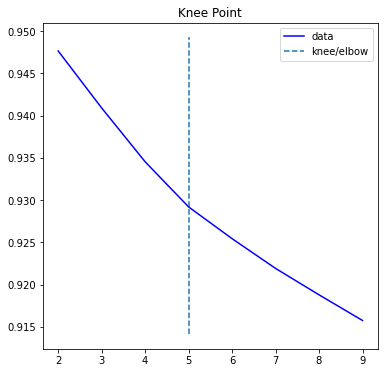

In [15]:
kneedle.plot_knee()

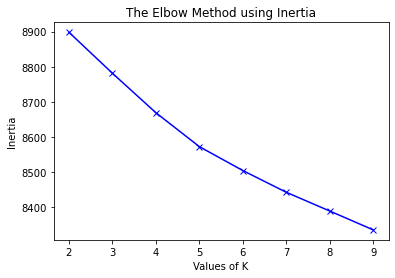

In [16]:
import matplotlib.pyplot as plt

plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

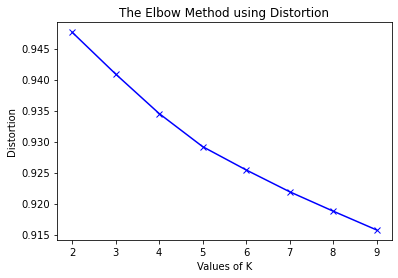

In [17]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [18]:
# save the clusterIDs to the dataframe
# minus 2 because we start checking with 2 clusters
df["kMeans_ID"] = all_kmeans_models[knee-2].labels_
df.head(3)

,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,clusterID,topic_percentage,topic_keywords,filtered_maintext,kMeans_ID
35,"07/14/2021, 01:04:12","07/14/2021, 01:04:12","06/12/2021, 15:53:42",By Pam Benson The intelligence community - not...,en,security.blogs.cnn.com,By Pam Benson The intelligence community - not...,Official: Changes to Benghazi talking points m...,https://security.blogs.cnn.com/2012/11/19/offi...,20,0.53227,"trump, president, king, obama, house, stone, h...",pam benson intelligence community white house ...,4
37,"07/14/2021, 01:04:12","07/14/2021, 01:04:12","06/12/2021, 15:22:34",To complete your CNN profile and ensure you ar...,en,www.cnn.com,To complete your CNN profile and ensure you ar...,Evan McMullin runs for White House to take on ...,https://www.cnn.com/2016/08/08/politics/evan-m...,20,0.98567,"trump, president, king, obama, house, stone, h...",profile account button conditions privacy poli...,2
60,"07/14/2021, 01:08:34","07/14/2021, 01:08:34","06/13/2021, 06:29:30",To complete your CNN profile and ensure you ar...,en,www.cnn.com,To complete your CNN profile and ensure you ar...,Deputy AG defends AP subpoenas | CNN,https://www.cnn.com/2013/05/14/us/justice-ap-p...,20,0.65164,"trump, president, king, obama, house, stone, h...",profile account button conditions privacy poli...,1


In [34]:
cluster_words_list = []
common_words = all_kmeans_models[knee-2].cluster_centers_.argsort()[:,-1:-11:-1]
for num, centroid in enumerate(common_words):
    cluster_words = []
    for word in centroid:
        cluster_words.append(words[word])
    cluster_words_list.append(cluster_words)
print(cluster_words_list)

[['biden', 'newsletters', 'manage', 'joe', 'election', 'impeachment', 'democrats', 'policy', 'privacy', 'sign'], ['mueller', 'investigation', 'fbi', 'russia', 'counsel', 'comey', 'attorney', 'intelligence', 'campaign', 'justice'], ['clinton', 'hillary', 'sanders', 'campaign', 'obama', 'candidate', 'donald', 'voter', 'election', 'bernie'], ['senate', 'republicans', 'party', 'democrats', 'republican', 'gop', 'vote', 'election', 'obama', 'sen'], ['obama', 'white', 'administration', 'security', 'donald', 'united', 'policy', 'official', 'bush', 'states']]


In [35]:
row_words = []
for index, row in df.iterrows():
    cluster = row.kMeans_ID
    row_words.append(cluster_words_list[cluster])
df['kMeans_words'] = row_words
df.head(3)


,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,clusterID,topic_percentage,topic_keywords,filtered_maintext,kMeans_ID,kMeans_words,month_year
35,"07/14/2021, 01:04:12","07/14/2021, 01:04:12",2021-06-12 15:53:42,By Pam Benson The intelligence community - not...,en,security.blogs.cnn.com,By Pam Benson The intelligence community - not...,Official: Changes to Benghazi talking points m...,https://security.blogs.cnn.com/2012/11/19/offi...,20,0.53227,"trump, president, king, obama, house, stone, h...",pam benson intelligence community white house ...,4,"[obama, white, administration, security, donal...",2021-06
37,"07/14/2021, 01:04:12","07/14/2021, 01:04:12",2021-06-12 15:22:34,To complete your CNN profile and ensure you ar...,en,www.cnn.com,To complete your CNN profile and ensure you ar...,Evan McMullin runs for White House to take on ...,https://www.cnn.com/2016/08/08/politics/evan-m...,20,0.98567,"trump, president, king, obama, house, stone, h...",profile account button conditions privacy poli...,2,"[clinton, hillary, sanders, campaign, obama, c...",2021-06
60,"07/14/2021, 01:08:34","07/14/2021, 01:08:34",2021-06-13 06:29:30,To complete your CNN profile and ensure you ar...,en,www.cnn.com,To complete your CNN profile and ensure you ar...,Deputy AG defends AP subpoenas | CNN,https://www.cnn.com/2013/05/14/us/justice-ap-p...,20,0.65164,"trump, president, king, obama, house, stone, h...",profile account button conditions privacy poli...,1,"[mueller, investigation, fbi, russia, counsel,...",2021-06


# Subcluster by release date

We will determine each articles release date and sort them into individual json files.

In [36]:
def getMonthYear(s):
     return s.split('-')[0]+"-"+s.split('-')[1]

import datetime as dt

df['date_publish'] = pd.to_datetime(df['date_publish'])
df['date_modify'] = pd.to_datetime(df['date_modify'])
df['date_modify'] = df['date_modify'].dt.strftime('%m/%d/%Y, %H:%M:%S')
df['date_download'] = pd.to_datetime(df['date_download'])
df['date_download'] = df['date_download'].dt.strftime('%m/%d/%Y, %H:%M:%S')
df['month_year'] = df['date_publish'].apply(lambda x: getMonthYear(str(x)))
df['date_publish'] = df['date_publish'].dt.strftime('%m/%d/%Y, %H:%M:%S')
df.head(3)

df = df.drop(columns=["maintext_prepro", "maintext_nouns", "maintext_ready", "corpus", "id"], errors='ignore')   #drop unwanted attributes that should not be output into the json files.
df.head()

# Generating folder structure

The following code creates the desired folder hierarchy and names each cluster after the top 3 dominant words in each one. Within each cluster/folder we are subclustering all articles by their release date.
The output json file has the format *year-month.json*. 

In [37]:
import datetime as dt
df['date_publish'] = pd.to_datetime(df['date_publish'])
df['month_year'] = df['date_publish'].apply(lambda x: getMonthYear(str(x)))
df.head(3)

,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,clusterID,topic_percentage,topic_keywords,filtered_maintext,kMeans_ID,kMeans_words,month_year
35,"07/14/2021, 01:04:12","07/14/2021, 01:04:12",2021-06-12 15:53:42,By Pam Benson The intelligence community - not...,en,security.blogs.cnn.com,By Pam Benson The intelligence community - not...,Official: Changes to Benghazi talking points m...,https://security.blogs.cnn.com/2012/11/19/offi...,20,0.53227,"trump, president, king, obama, house, stone, h...",pam benson intelligence community white house ...,4,"[obama, white, administration, security, donal...",2021-06
37,"07/14/2021, 01:04:12","07/14/2021, 01:04:12",2021-06-12 15:22:34,To complete your CNN profile and ensure you ar...,en,www.cnn.com,To complete your CNN profile and ensure you ar...,Evan McMullin runs for White House to take on ...,https://www.cnn.com/2016/08/08/politics/evan-m...,20,0.98567,"trump, president, king, obama, house, stone, h...",profile account button conditions privacy poli...,2,"[clinton, hillary, sanders, campaign, obama, c...",2021-06
60,"07/14/2021, 01:08:34","07/14/2021, 01:08:34",2021-06-13 06:29:30,To complete your CNN profile and ensure you ar...,en,www.cnn.com,To complete your CNN profile and ensure you ar...,Deputy AG defends AP subpoenas | CNN,https://www.cnn.com/2013/05/14/us/justice-ap-p...,20,0.65164,"trump, president, king, obama, house, stone, h...",profile account button conditions privacy poli...,1,"[mueller, investigation, fbi, russia, counsel,...",2021-06


In [46]:
import os
import json

for cluster_id, data in df.groupby(df.kMeans_ID):
    item = data.kMeans_words.tolist()
    item = item[0]
    os.makedirs(f'./event_clustered_json/cluster_{cluster_id}-{item[0]}_{item[1]}_{item[2]}')
    for date, date_data in data.groupby(data.month_year):
        json_data = date_data.to_json(orient='records', force_ascii=False, date_format='iso', date_unit='s')
        parsed = json.loads(json_data)
        with open(f'./event_clustered_json/cluster_{cluster_id}-{item[0]}_{item[1]}_{item[2]}/{date}.json', 'w', encoding='utf-8') as f:
            f.write(json.dumps({"data": parsed}, indent=4, ensure_ascii=False))